In [2]:
import numpy as np
import chaospy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

# parameters

In [101]:
# Total number of sample points
N = 2**13 # 8192

# interval of alpha grid
dalp = (0.98-0.02)/30   # 0.032

# range of alpha
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

# dimension of inputs
dim = np.size(miu) # 4



# Test 1: Linear function

In [102]:
# mean for normal distribution
miu = np.array([1,3,5,7])

# standard deviation for normal distribution
sd = np.array([1,1.5,2,2.5])

a = [1,1,1,1]

def objfun(x):
    result = a[0]*x[:,0]+a[1]*x[:,1]+a[2]*x[:,2]+a[3]*x[:,3]
    return result

## kucherenko_quantile function

In [217]:
def kucherenko_quantile(alp,N,miu,sd):
    q1_alp, q2_alp = _quantile_based_measures(N,M,dim,alp)
    Q1_alp, Q2_alp = _nomalized_quantile_based_measures(N,M,dim,alp)
    
    return q1_alp, q2_alp, Q1_alp, Q2_alp


def _quantile_based_measures(N,M,dim,alp):
    # shape(1, 4, 1, 64)
    delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)
    q1_alp=np.zeros((len(alp),dim))
    q2_alp=np.zeros((len(alp),dim))
    
    qy_alp1 = _unconditional_q_Y(N,M,dim)
    qy_alp2 = _conditional_q_Y(N,M,dim,alp)
    
    for i in range(dim):
        for pp in range(len(alp)):
            delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
            q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
            q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2
            
    return q1_alp, q2_alp


def _nomalized_quantile_based_measures(N,M,dim,alp):
    # shape(1, 31)
    q1=np.zeros(len(alp))
    q2=np.zeros(len(alp))

    Q1_alp=np.zeros((len(alp),dim))
    Q2_alp=np.zeros((len(alp),dim))
    
    q1_alp, q2_alp = _quantile_based_measures(N,M,dim,alp)
    
    for pp in range(len(alp)):
        q1[pp]=np.sum(q1_alp[pp,:])
        q2[pp]=np.sum(q2_alp[pp,:])
        for i in range(dim):
            Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
            Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]
    
    return Q1_alp, Q2_alp


def _unconditional_q_Y(N,M,dim):
    A,B  = _get_samples(N, M, dim)
    # values of outputs
    Y1 = objfun(A)
    # reorder in ascending order
    y1 = np.sort(Y1)
    
    # q_Y(alp)
    q_index = (np.floor(alp*N)-1).astype(int)
    qy_alp1 = y1[q_index]
    
    return qy_alp1 


def _conditional_q_Y(N,M,dim,alp):
    A,B  = _get_samples(N, M, dim)
    
    # conditional sample matrix C,with shape(64, 4, 8192, 4)
    C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

    for i in range(dim):
        for j in range(M):
            C[j,i] = A
            C[j,i,:,i] = B[j, i]  
    # values of conditional outputs
    # shape(8192, 4, 8192, 1)
    Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
    y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
    
    # shape(1, 4, 31, 64)
    qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)
    
    for i in range(dim):
        for j in range(M):
            Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
            Y2[j,i].sort(axis=0)
            y2[j,i] = Y2[j,i] # reorder in ascending order
            for pp in range(len(alp)):
                qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)
    
    return qy_alp2


def _get_samples(N, M, dim):
    
    # A for unconditional sample
    A = np.zeros((N,dim))
    # B for conditional sample
    B = np.zeros((M,dim))
    X01 = cp.generate_samples(order=N, domain=dim, rule="S").T
    X02 = cp.generate_samples(order=M, domain=dim, rule="S").T
    
    A = norm.ppf(X01,loc=miu, scale=sd)
    B = norm.ppf(X02,loc=miu, scale=sd)

    return A,B

In [218]:
q1_alp, q2_alp, Q1_alp, Q2_alp=kucherenko_quantile(alp,N,miu,sd)

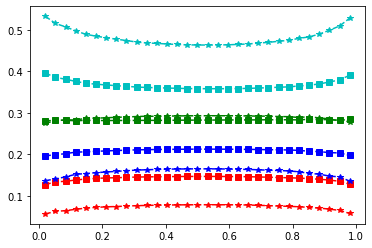

In [219]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')

## solve q_Y(alp)

In [85]:
# number of conditional samples
M = 64

In [86]:
A = np.zeros((N,dim))
B = np.zeros((M,dim))

In [105]:
# alpha的sample
X01 = cp.generate_samples(order=N, domain=dim, rule="S").T
X02 = cp.generate_samples(order=M, domain=dim, rule="S").T

X01[0:10,:]

array([[0.5   , 0.5   , 0.5   , 0.5   ],
       [0.75  , 0.25  , 0.75  , 0.25  ],
       [0.25  , 0.75  , 0.25  , 0.75  ],
       [0.375 , 0.375 , 0.625 , 0.125 ],
       [0.875 , 0.875 , 0.125 , 0.625 ],
       [0.625 , 0.125 , 0.375 , 0.375 ],
       [0.125 , 0.625 , 0.875 , 0.875 ],
       [0.1875, 0.3125, 0.3125, 0.6875],
       [0.6875, 0.8125, 0.8125, 0.1875],
       [0.9375, 0.0625, 0.5625, 0.9375]])

In [99]:
# X1 = norm.ppf(X01)
# X2 = norm.ppf(X02)

# for i in range(dim):
#     A[:,i] = X1[:,i]*sd[i]+miu[i]
#     B[:,i] = X2[:,i]*sd[i]+miu[i]

In [103]:
# input的sample
A = norm.ppf(X01,loc=miu, scale=sd)
B = norm.ppf(X02,loc=miu, scale=sd)

In [104]:
A

array([[ 1.        ,  3.        ,  5.        ,  7.        ],
       [ 1.67448975,  1.98826537,  6.3489795 ,  5.31377562],
       [ 0.32551025,  4.01173463,  3.6510205 ,  8.68622438],
       ...,
       [ 1.00030598,  0.24896359, -0.38610818,  5.05997948],
       [-2.66832929,  3.1254469 ,  5.01774736,  8.44873513],
       [-2.56330774,  2.06559284,  6.35782791,  9.36755323]])

In [202]:
# values of outputs
Y1 = objfun(A)

In [203]:
# reorder in ascending order
y1 = np.sort(Y1)


In [204]:
# q_Y(alp)
q_index = (np.floor(alp*N)-1).astype(int)
qy_alp1 = y1[q_index]

## solve conditional q_Y(alp)

In [205]:
# conditional sample matrix C,with shape(64, 4, 8192, 4)
C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

for i in range(dim):
    for j in range(M):
        C[j,i] = A
        C[j,i,:,i] = B[j, i]  
         

In [206]:
# values of conditional outputs
# shape(8192, 4, 8192, 1)
Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)

In [207]:
# shape(1, 4, 31, 64)
qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [208]:
for i in range(dim):
    for j in range(M):
        Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
        Y2[j,i].sort(axis=0)
        y2[j,i] = Y2[j,i] # reorder in ascending order
        for pp in range(len(alp)):
            qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)

## solve q_1(alp)  and  q_2(alp)

In [209]:
# shape(1, 4, 1, 64)
delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [210]:
q1_alp=np.zeros((len(alp),dim))
q2_alp=np.zeros((len(alp),dim))

In [211]:
for i in range(dim):
    for pp in range(len(alp)):
        delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
        q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
        q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2

## solve Q_1(alp)  and  Q_2(alp)

In [212]:
# shape(1, 31)
q1=np.zeros(len(alp))
q2=np.zeros(len(alp))


Q1_alp=np.zeros((len(alp),dim))
Q2_alp=np.zeros((len(alp),dim))

In [213]:
for pp in range(len(alp)):
    q1[pp]=np.sum(q1_alp[pp,:])
    q2[pp]=np.sum(q2_alp[pp,:])
    for i in range(dim):
        Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
        Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]


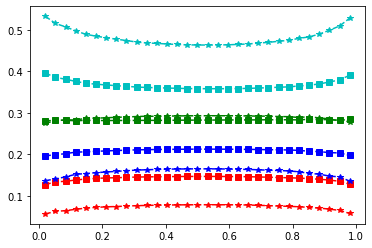

In [214]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')


# Test 2: $Y=x_1+x_2+x_3-x_4$

In [2]:
from scipy.stats import expon


In [4]:
# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64



In [5]:


a = [1,-1,1,-1]

def objfun(x):
    result = a[0]*x[:,0]+a[1]*x[:,1]+a[2]*x[:,2]+a[3]*x[:,3]
    return result


# dimension of inputs
dim = np.size(a) # 4

In [6]:
A = np.zeros((N,dim))
B = np.zeros((M,dim))

In [94]:
X01 = cp.generate_samples(order=N, domain=dim, rule="S").T
X02 = cp.generate_samples(order=M, domain=dim, rule="S").T

In [98]:
A = expon.ppf(X01)
B = expon.ppf(X02)


NameError: name 'expon' is not defined

In [9]:
Y1 = objfun(A)

In [10]:
y1 = np.sort(Y1)

In [11]:
q_index = (np.floor(alp*N)-1).astype(int)
qy_alp1 = y1[q_index]

In [13]:
# conditional sample matrix C,with shape(64, 4, 8192, 4)
C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

for i in range(dim):
    for j in range(M):
        C[j,i] = A
        C[j,i,:,i] = B[j, i] 

In [14]:
# values of conditional outputs
# shape(8192, 4, 8192, 1)
Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)

In [15]:
# shape(1, 4, 31, 64)
qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [17]:
for i in range(dim):
    for j in range(M):
        Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
        Y2[j,i].sort(axis=0)
        y2[j,i] = Y2[j,i] # reorder in ascending order
        for pp in range(len(alp)):
            qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)

In [18]:
# shape(1, 4, 1, 64)
delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [19]:
q1_alp=np.zeros((len(alp),dim))
q2_alp=np.zeros((len(alp),dim))

In [20]:
for i in range(dim):
    for pp in range(len(alp)):
        delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
        q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
        q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2

In [21]:
# shape(1, 31)
q1=np.zeros(len(alp))
q2=np.zeros(len(alp))


Q1_alp=np.zeros((len(alp),dim))
Q2_alp=np.zeros((len(alp),dim))

In [22]:
for pp in range(len(alp)):
    q1[pp]=np.sum(q1_alp[pp,:])
    q2[pp]=np.sum(q2_alp[pp,:])
    for i in range(dim):
        Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
        Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]


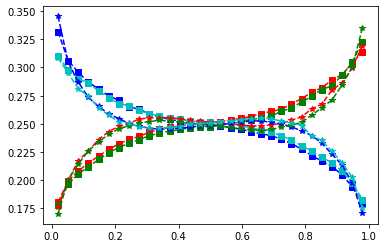

In [24]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')

# Test 3: $Y=sin(x_1)+7(sin x_2)^2+0.1x_3^4sin(x_1)$

In [143]:
def objfun(x):

    result = np.sin(x[:,0]) + 7 * np.sin(x[:,1])**2 + 0.1 * x[:,2]**4*np.sin(x[:,0])
    
    return result

dim = 3

In [144]:
# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

In [145]:
A = np.zeros((N,dim))
B = np.zeros((M,dim))

In [146]:
X01 = cp.generate_samples(order=N, domain=dim, rule="S").T
X02 = cp.generate_samples(order=M, domain=dim, rule="S").T

In [147]:
from scipy.stats import uniform

A = uniform.ppf(X01,loc=-np.pi,scale=2*np.pi)
B = uniform.ppf(X02,loc=-np.pi,scale=2*np.pi)

In [148]:
Y1 = objfun(A)

In [149]:
y1 = np.sort(Y1)

In [150]:
q_index = (np.floor(alp*N)-1).astype(int)


In [151]:
qy_alp1 = y1[q_index]

In [152]:
C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

for i in range(dim):
    for j in range(M):
        C[j,i] = A
        C[j,i,:,i] = B[j, i] 

In [153]:
# values of conditional outputs
# shape(8192, 4, 8192, 1)
Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)

In [154]:
# shape(1, 4, 31, 64)
qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [155]:
for i in range(dim):
    for j in range(M):
        Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
        Y2[j,i].sort(axis=0)
        y2[j,i] = Y2[j,i] # reorder in ascending order
        for pp in range(len(alp)):
            qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)

In [156]:
# shape(1, 4, 1, 64)
delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [157]:
q1_alp=np.zeros((len(alp),dim))
q2_alp=np.zeros((len(alp),dim))

In [158]:
for i in range(dim):
    for pp in range(len(alp)):
        delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
        q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
        q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2

In [159]:
# shape(1, 31)
q1=np.zeros(len(alp))
q2=np.zeros(len(alp))


Q1_alp=np.zeros((len(alp),dim))
Q2_alp=np.zeros((len(alp),dim))

In [160]:
for pp in range(len(alp)):
    q1[pp]=np.sum(q1_alp[pp,:])
    q2[pp]=np.sum(q2_alp[pp,:])
    for i in range(dim):
        Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
        Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]

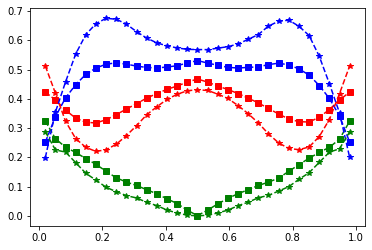

In [162]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--')

# Test 4: $Y=x_1 x_2+x_3 x_4$

In [106]:

miu = np.array([0, 0, 250, 400])

cov = np.array(
    [
        [16, 2.4, 0, 0],
        [2.4, 4, 0, 0],
        [0, 0, 40000, -18000],
        [0, 0, -18000, 90000],
    ],
)


In [107]:
def objfun(x):

    result = x[:,0]*x[:,1]+x[:,2]*x[:,3]
    
    return result

dim = np.size(miu)

In [108]:
# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

In [109]:
A = np.zeros((N,dim))
B = np.zeros((M,dim))

In [110]:
# get_uniform_base_draws
X01 = cp.generate_samples(order=N, domain=dim, rule="S").T
X02 = cp.generate_samples(order=M, domain=dim, rule="S").T

In [113]:
# from scipy.stats import multivariate_normal

norm.ppf(X01)
# X1 = multivariate_normal.cdf(X01,miu,cov)
# X2 = multivariate_normal.cdf(X02,miu,cov)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 6.74489750e-01, -6.74489750e-01,  6.74489750e-01,
        -6.74489750e-01],
       [-6.74489750e-01,  6.74489750e-01, -6.74489750e-01,
         6.74489750e-01],
       ...,
       [ 3.05984902e-04, -1.83402428e+00, -2.69305409e+00,
        -7.76008206e-01],
       [-3.66832929e+00,  8.36312634e-02,  8.87367846e-03,
         5.79494051e-01],
       [-3.56330774e+00, -6.22938107e-01,  6.78913955e-01,
         9.47021291e-01]])

In [114]:
# uniform_to_multivariate_normal
X1 = norm.ppf(X01)
X1 = norm.ppf(X02)

cholesky = np.linalg.cholesky(cov)

A = miu + cholesky.dot(X01.T).T
B = miu + cholesky.dot(X02.T).T


In [133]:
cholesky.dot(X01.T).T.shape

(8192, 4)

In [43]:
multivariate_draws_1.shape

(8192, 4)

In [56]:
q2=np.quantile(X2, alp, axis=0)
q1=np.quantile(X1, alp, axis=0)

array([341.87437047, 361.87910818, 375.70261252, 387.56321736,
       397.21478262, 406.4828997 , 415.72858258, 424.83578811,
       433.96342483, 443.13386842, 452.12376187, 461.41407203,
       470.94898537, 479.87082929, 488.76563153, 498.0933798 ,
       507.25886692, 516.37825956, 525.53320465, 534.71936858,
       543.92210505, 553.11377772, 562.26554321, 571.21844935,
       580.50258567, 589.73360335, 598.79453746, 608.81804671,
       620.28447861, 634.49751817, 654.16976848])

In [116]:
Y1 = objfun(A)
Y1

array([174334.31595279, 161620.95695131, 177642.47700445, ...,
       115907.70037767, 196540.08966099, 227914.01988558])

In [117]:
y1 = np.sort(Y1)

In [118]:
q_index = (np.floor(alp*N)-1).astype(int)

In [119]:
qy_alp1 = y1[q_index]

In [120]:
C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

for i in range(dim):
    for j in range(M):
        C[j,i] = A
        C[j,i,:,i] = B[j, i] 

In [121]:
# values of conditional outputs
# shape(8192, 4, 8192, 1)
Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)

In [122]:
# shape(1, 4, 31, 64)
qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [123]:
for i in range(dim):
    for j in range(M):
        Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
        Y2[j,i].sort(axis=0)
        y2[j,i] = Y2[j,i] # reorder in ascending order
        for pp in range(len(alp)):
            qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)

In [124]:
# shape(1, 4, 1, 64)
delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [125]:
q1_alp=np.zeros((len(alp),dim))
q2_alp=np.zeros((len(alp),dim))

In [126]:
for i in range(dim):
    for pp in range(len(alp)):
        delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
        q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
        q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2

In [127]:
# shape(1, 31)
q1=np.zeros(len(alp))
q2=np.zeros(len(alp))


Q1_alp=np.zeros((len(alp),dim))
Q2_alp=np.zeros((len(alp),dim))

In [128]:
for pp in range(len(alp)):
    q1[pp]=np.sum(q1_alp[pp,:])
    q2[pp]=np.sum(q2_alp[pp,:])
    for i in range(dim):
        Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
        Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]

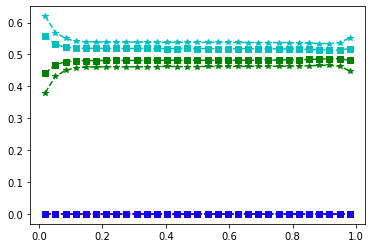

In [129]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')